<h1>Smart Grid Stability</h1>

<p> Aquest Dataset tracta sobre l'estabilitat d'una red elèctrica intel·ligent, tenim diferents atributs amb uns valors diferents, i podem saber quan la red elèctrica és estable o no </p>



<p> Primer el que hem fet és carregar la base de dades per tal de saber com és i com tractarem les dades, i investigar una mica els valors que hi ha en ella </p>

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split

def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset
dataset = load_dataset('dataBase/smart_grid_stability_augmented.csv')
dataTest=load_dataset('dataBase/smart_grid_stability_augmented_test.csv')

print("Dimensionalitat del conjunt del train:", dataset.shape)
print("Dimensionalitat del conjunt test:", dataTest.shape)

Dimensionalitat del conjunt del train: (60000, 14)
Dimensionalitat del conjunt test: (29998, 14)


## Tipus de Dades

Com podem observar les dades són tipus float, i el últim atribut, que és el atribut target, és tipus object, però com són dos resultats el transformarem a binari i així podrem treballar sense problemes i arribar a una conclusió.

In [61]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    60000 non-null  float64
 1   tau2    60000 non-null  float64
 2   tau3    60000 non-null  float64
 3   tau4    60000 non-null  float64
 4   p1      60000 non-null  float64
 5   p2      60000 non-null  float64
 6   p3      60000 non-null  float64
 7   p4      60000 non-null  float64
 8   g1      60000 non-null  float64
 9   g2      60000 non-null  float64
 10  g3      60000 non-null  float64
 11  g4      60000 non-null  float64
 12  stab    60000 non-null  float64
 13  stabf   60000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 6.4+ MB


<p> El que faré a continuació, és veure si en la nostra base de dades hi ha valors nulls, si hi haguès, els hauriem de tractar, en aquest cas hem vist que no hi ha, per tant no hem de tractar cap valor null de moment</p>

In [62]:
missing_value=pd.DataFrame(dataset.isna().sum().sort_values(ascending=False),columns=['Column'])
missing_value['%']=(dataset.isna().sum()/60000)*100
missing_value

,Column,%
tau1,0,0.0
tau2,0,0.0
tau3,0,0.0
tau4,0,0.0
p1,0,0.0
p2,0,0.0
p3,0,0.0
p4,0,0.0
g1,0,0.0
g2,0,0.0



## Correlació entre les dades
El que fem a continuació, és mirar la correlació de les dades, mirem atribut per atribut, i extreiem les notres pròpies conclusions sobre quines columnes són importants a estudiar pel nostre atribut target

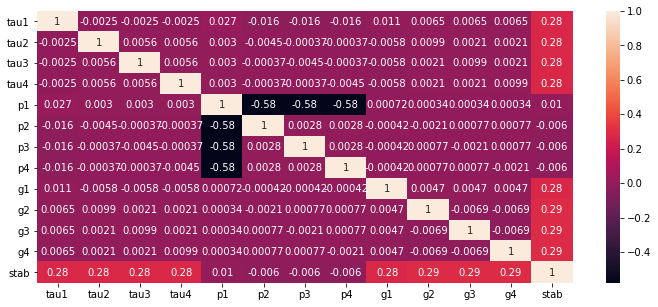

In [63]:
import seaborn as sns
correlacio=dataset.corr()
plt.figure(figsize=(12,5))
sns.heatmap(correlacio,annot=True)
plt.show()

<p>Hem vist que la columna p1, p2, p3, p4 no hi ha molta bona correlació amb les altres columnes, per tant, he dicidit treure-les i així no les tinc en compte a la hora d'aplicar un mòdel, i és més fàcil de treballar amb menys dades, també eliminarem el atribut stab, perquè té una directe relació amb l'atribut escollit com a target stabf, per tant l'eliminem perquè sino ens portarà problemes a la hora de classificar</p>

In [64]:
dataset=dataset.drop(['p1', 'p2','p3','p4','stab'],axis=1)
dataTest=dataTest.drop(['p1', 'p2','p3','p4','stab'],axis=1)


<p>El que vaig pensar per estudiar una mica més les dades, va ser mirar la distribució de les dades, i extreure conclusions, i per veure si les dades estan molt juntes o no, haig de dir que el dataset que ens ha tocat, és una mica dificíl d'estudiar ja que les dades estàn molt juntes, pot ser que això ens dongui problemes al arribar a una conclusió final</p>

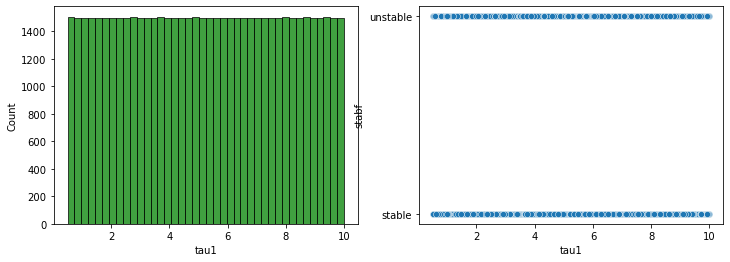

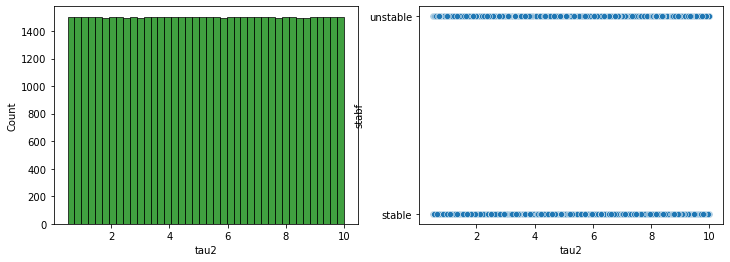

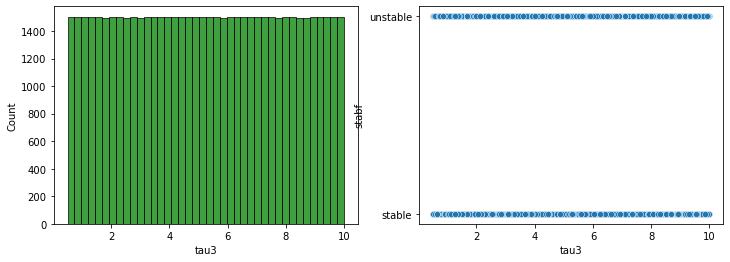

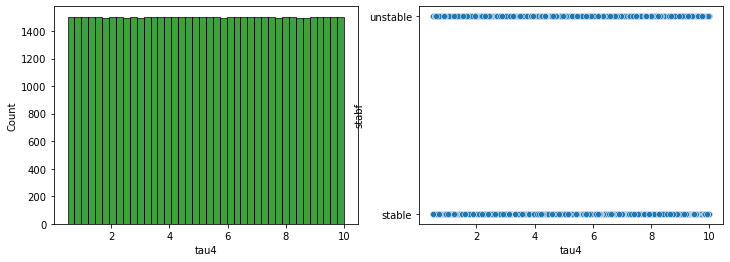

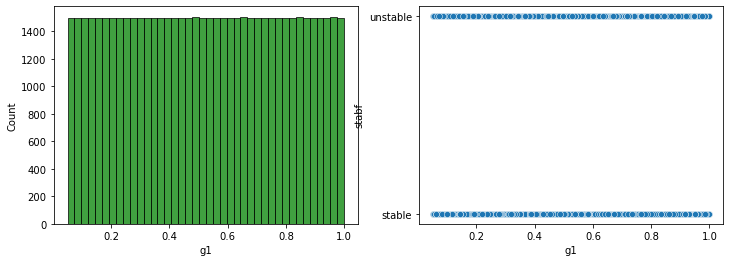

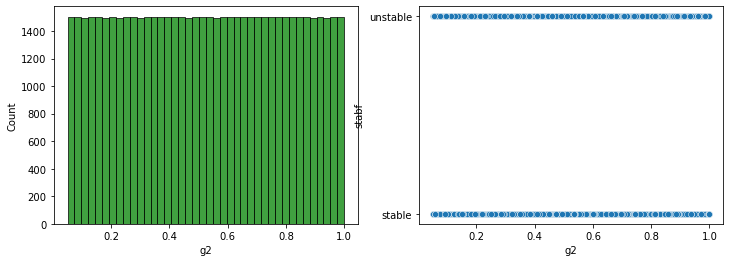

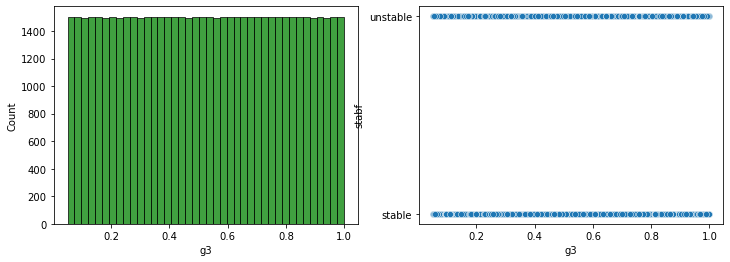

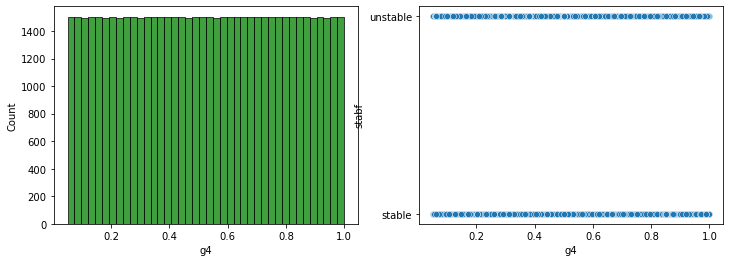

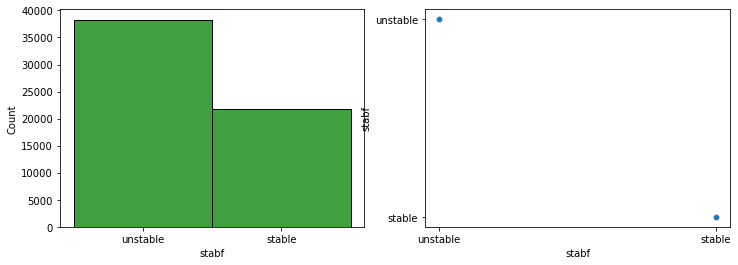

In [65]:
for column in dataset:
    plot_fig, plot_axes = plt.subplots(1, 2, figsize = (12, 4))
    chart_1 = sns.histplot(x=dataset[column], ax = plot_axes[0], color='g')
    
    chart_2 = sns.scatterplot(x = column, y = 'stabf', data = dataset, ax = plot_axes[1])

    plt.show()
del plot_fig, plot_axes

<p> Com he comentat anteriorment el resultat final o sigui el atribut target és binari, o sigui que la red elèctrica sigui estable o inestable, el que faré es convertir el resultats amb '1' i '0', el '1' correspondrà a inestable i el '0' correspondrà a estable</p>

In [66]:
d={'unstable':1,'stable':0}
dataset['stabf']=dataset.stabf.map(d)
dataTest['stabf']=dataTest.stabf.map(d)
dataTest


,tau1,tau2,tau3,tau4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,0.650456,0.859578,0.887445,0.958034,1
1,9.304097,4.902524,3.047541,1.369357,0.413441,0.862414,0.562139,0.781760,0
2,8.971707,8.848428,3.046479,1.214518,0.163041,0.766689,0.839444,0.109853,1
3,0.716415,7.669600,4.486641,2.340563,0.446209,0.976744,0.929381,0.362718,1
4,3.134112,7.608772,4.943759,9.857573,0.797110,0.455450,0.656947,0.820923,1
...,...,...,...,...,...,...,...,...,...
29993,5.754191,5.084803,4.633624,3.032743,0.157284,0.511555,0.696591,0.975921,1
29994,2.042954,8.173809,5.466635,8.514335,0.154129,0.053225,0.499109,0.944486,1
29995,2.930406,2.376523,6.187797,9.487627,0.601709,0.813512,0.608385,0.779642,1
29996,3.392299,2.954947,6.894759,1.274827,0.502079,0.285880,0.366120,0.567242,0


## Models a implementar

<h3>1. Regressor logistic</h3>
<h3>2. SVM</h3>
<h3>3. MLP (Multiple layer perception</h3>
<h3>4. MLP amb millors parametres</h3>


In [67]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

<h3>Implementació Regressor logistic</h3>

In [68]:
def RegresorLogistic(x,y,particio):
    for size in particio:
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=size , test_size = 1-size)
        logireg = LogisticRegression(C=2.0, fit_intercept=True, penalty='l2')
        logireg.fit(x_train, y_train)
        print("Accuracy Logistic: ",logireg.score(x_test, y_test), " amb el ", size, " del dataset")
    

<h3>Resultats del regressor logístic amb diferents particions</h3>

In [69]:
particio = [0.1,0.3,0.5,0.8]
x = dataset.drop(["stabf"],axis=1).values
y = dataset["stabf"].values

print("Logistic amb dataTotal i particio sobre el dataset")
RegresorLogistic(x,y,particio)

x = dataTest.drop(["stabf"],axis=1).values
y = dataTest["stabf"].values

print("")
print("Logistic amb dataTest i particio sobre el data set")
RegresorLogistic(x,y,particio)

Logistic amb dataTotal i particio sobre el dataset
Accuracy Logistic:  0.8145  amb el  0.1  del dataset
Accuracy Logistic:  0.8129761904761905  amb el  0.3  del dataset
Accuracy Logistic:  0.8116  amb el  0.5  del dataset
Accuracy Logistic:  0.8145833333333333  amb el  0.8  del dataset

Logistic amb dataTest i particio sobre el data set
Accuracy Logistic:  0.8148820326678766  amb el  0.1  del dataset
Accuracy Logistic:  0.8159912376779846  amb el  0.3  del dataset
Accuracy Logistic:  0.8155877058470564  amb el  0.5  del dataset
Accuracy Logistic:  0.8166666666666667  amb el  0.8  del dataset


In [70]:
from sklearn.preprocessing import StandardScaler

x_train = dataset.drop(["stabf"],axis=1).values
y_train = dataset["stabf"].values
x_test =dataTest.drop(["stabf"],axis=1).values
y_test = dataTest["stabf"].values

ss = StandardScaler(with_mean=False,with_std=False).fit(x_train)
x_train_scaled = ss.transform(x_train)
x_test_scaled = ss.transform(x_test)


<h3>Resultats finals del regressor logístic</h3>

In [71]:
LR_time=0
start = time.time()
logireg = LogisticRegression()
logireg.fit(x_train, y_train)
rl_score = logireg.score(x_test, y_test)
print("Accuracy Logistic: ",rl_score)
end = time.time()
LR_time = LR_time + (end - start)
print(LR_time)

logireg.fit(x_train_scaled, y_train)
rl_score_scaled = logireg.score(x_test_scaled, y_test)

print("Accuracy Logistic dades escalades: ",rl_score_scaled)

Accuracy Logistic:  0.8141876125075005
0.11812210083007812
Accuracy Logistic dades escalades:  0.8141876125075005


<h3>Implementació i resultats del model MLP </h3>

In [72]:

from sklearn.neural_network import MLPClassifier
MLP_time=0
start=time.time()
mlp = MLPClassifier()

mlp.fit(x_train,y_train)
mpl_score_0 = mlp.score(x_test, y_test)

print("Accuracy MLP: ",mpl_score_0)
end = time.time()
MLP_time = MLP_time + (end - start)
print(MLP_time)
mlp.fit(x_train_scaled,y_train)

mlp_score_scaled_0 = mlp.score(x_test_scaled, y_test)
print("Accuracy MLP dades escalades: ",mlp_score_scaled_0)

Accuracy MLP:  0.9776651776785119
21.742024898529053
Accuracy MLP dades escalades:  0.9759317287819188


/Users/francesc24/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<h3>Implementació del model SVM</h3>
<br>
El que farem per poder executar el model SVM es reduir la base de dades, ja que amb tota la base de dades doncs
triga molt en executar-se i mostrar els resultats, com podem observar a continuació hem reduit el tamany a 10000 files

In [73]:
from sklearn.utils import shuffle
size = 10000
x_s, y_s = shuffle(x_train,y_train)

print(x_train[:size-1].shape)

x_mini_train = x_s[:size-1]
y_mini_train = y_s[:size-1]
x_mini_test = x_test[:size-1]
y_mini_test = y_test[:size-1]

x_mini_train_scaled = x_train_scaled[:size-1]
x_mini_test_scaled = x_test_scaled[:size-1]

(9999, 8)


In [74]:

from sklearn.svm import SVC
SVM_time=0
start=time.time()
svc = SVC(C=10)
svc.fit(x_mini_train, y_mini_train)
svc_score = svc.score(x_mini_test, y_mini_test)
print("Accuracy SVM",svc_score,"amb",size,"files")
end=time.time()
SVM_time = SVM_time + (end - start)
print(SVM_time)
svc.fit(x_mini_train_scaled, y_mini_train)
svc_score_scaled = svc.score(x_mini_test_scaled, y_mini_test)
print("Accuracy SVM amb dades escalades",svc_score_scaled,"amb",size,"files")

Accuracy SVM 0.9557955795579558 amb 10000 files
0.9303312301635742
Accuracy SVM amb dades escalades 0.637963796379638 amb 10000 files


<h3>Implementació del MLP amb els millors paràmentres</h3>

In [75]:
a=0.0001
lr = 0.001
MLPbetter_time=0
start=time.time()
mlp = MLPClassifier(alpha=a,learning_rate_init=lr)

mlp.fit(x_train,y_train)
mlp_score = mlp.score(x_test, y_test)

print("Accuracy MLP:",mlp_score,"amb alpha =", a, "i learning rate=", lr)
end=time.time()
MLPbetter_time = MLPbetter_time + (end - start)
print(MLPbetter_time)
mlp.fit(x_train_scaled,y_train)
mlp_score_scaled = mlp.score(x_test_scaled, y_test)

print("Accuracy MLP scaled:",mlp_score_scaled,"amb alpha =", a, "i learning rate=", lr) 

Accuracy MLP: 0.9780985399026602 amb alpha = 0.0001 i learning rate= 0.001
23.2927029132843
Accuracy MLP scaled: 0.9713314220948063 amb alpha = 0.0001 i learning rate= 0.001


/Users/francesc24/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<h3>Anàlisis de resultats</h3>

Color Taronge: Dades tipus Test
<br>
Color blau: Dades tipu Train

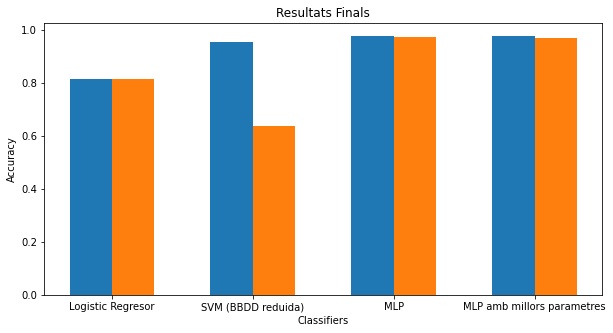

In [77]:
x = ['Logistic Regresor', 'SVM (BBDD reduida)', 'MLP','MLP amb millors parametres']
x_axis = np.arange(len(x))
plt.figure(figsize=(10, 5))
plt.bar(x_axis-0.15, [rl_score, svc_score,mpl_score_0,mlp_score], 0.3, label='Sense escalat')
plt.bar(x_axis+0.15, [rl_score_scaled, svc_score_scaled,mlp_score_scaled_0,mlp_score_scaled], 0.3, label='Amb escalat')
plt.xticks(x_axis, x)
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Resultats Finals')
plt.show()

<h3> Taula de Resultats </h3>

| Model | Temps d'execució | Accuracy del test |
|-----------|:------------|:-----------:|
| Regressió Logística | 0.1181 s | 81,4% | 
| MLP |21.742s | 97,7%|
| SVM | 0.9303 s | 95.58% |
| MLP amb millors paràmetres | 23.292s | 97.80% |


Un cop que ja hem obtingut els nostres resultats de les prediccionas del set de test, podem veure que els nostres models implementats per aquesta base de dades estan funcionantn molt bé, ja que estem obtenint uns valors de accuracy de més del 90%.

M'ha sorprès molt que una base de dades com aquesta amb una correlació força normal, pugui tenir una classificació molt bona, també haig de dir que el SVM classifica bé amb la BD reduïda però amb una quantitat menor de 10000 dades, el resultat es veu bastant reduït, amb un accuracy sobre el 60%.

Com es pot veure en la taula, el pitjor dels casos és la regressió logistica, que ens ha donat un accuracy força bo, però és el més baix dels 4 models. En canvim el millor model amb l'accuracy més alt ha sigut el MLP amb millors paràmetres, ja que ens ha donat un resultat de 97.8%, però el temps d'execució d'aquest model és força lent ja que el learning rate l'hem baixat bastant i triga molt en fer les iteracions, tot i així amb el resultat que hem obtingut podem dir que aquest model per classificar les dades val molt la pena.

També vaig provar de escalar les dades per tal d'obtenir millor resultats, però com heu pogut veure en les execucions del codi, la diferència de resultats no varia molt, per tant vaig decidir plasmar els resultats sense les dades escalades.
